# TPN°1 - NLP2 - CEIA - TinyGPT

**Autor: Joaquin Gonzalez**

## Consigna

Usando TinyGPT debes implementar las siguientes modificaciones:


1) Inferencia: modifica la función `generate` para:

    - Decodificación *greedy* (seleccionar el token con mayor probabilidad).
    - Muestreo por temperatura.
    - Muestreo *top‑k* o *top‑p*.

2) Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.


3) Conclusiones 


**NOTA**
La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.


## Utils

In [1]:
# Instala los paquetes listados en requirements.txt
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import httpx
import torch
from torch import nn
import torch.nn.functional as F
from typing import Optional, List, Type
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

# Instancia del Trainer y MetricsLogger
from metrics_logger import MetricsLogger


## Dataset

In [3]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## Preparación del modelo TinyGPT

### Preparación del modelo y arquitectura

#### Codificación basada en caracteres

In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# División entrenamiento/prueba
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

#### Cargadores de datos

In [5]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

#### Configuración de GPT

In [6]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 512
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 512, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [7]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

In [8]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

# Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

# Atención de producto punto escalado
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [10]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

#### Arquitectura de TinyGPT

In [11]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

### Inferencia

#### Función de generación (inferencia)

In [12]:
@torch.no_grad()
def generate(model: torch.nn.Module, prompt: str, max_new_tokens: int = 100, use_cache: bool = True, device: torch.device = torch.device("cpu")):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

#### Configuración

In [13]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [14]:
epochs = 27

optimizer = AdamW(model.parameters(), lr=1e-3)
total_steps = len(train_loader) * epochs
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

### Entrenamiento

In [ ]:
logger = MetricsLogger("tinygpt_metrics.json")

trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)

# Entrenamiento con logging
logger.start_training()

for epoch in range(epochs):
    logger.start_epoch()
    
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    val_loss = trainer.eval_model()
    
    # Corregir la pérdida de entrenamiento si está dividida por gradient_accumulation_steps
    corrected_train_loss = avg_train_loss * trainer.gradient_accumulation_steps
    
    # Log de métricas
    logger.log_epoch(corrected_train_loss, val_loss)

logger.end_training()
logger.save_metrics()

print("Entrenamiento completo.")

  0%|          | 0/175 [00:00<?, ?it/s]/home/jgonzalez/dev/.virtualenv/ceia-nlp-II-tp-1/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2509: UserWarning: NVIDIA GeForce GTX 1650 Ti does not support bfloat16 compilation natively, skipping
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/ceia-nlp-II-tp-1/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2509: UserWarning: NVIDIA GeForce GTX 1650 Ti does not support bfloat16 compilation natively, skipping
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/ceia-nlp-II-tp-1/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2509: UserWarning: NVIDIA GeForce GTX 1650 Ti does not support bfloat16 compilation natively, skipping
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/ceia-nlp-II-tp-1/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2509: UserWarning: NVIDIA GeForce GTX 1650 Ti does not support bfloat16 compilation natively, skipping
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/ceia-nlp-II-tp-1/

Época 1 - Train Loss: 2.2377 - Val Loss: 2.1611
Train Perplexity: 9.3720 - Val Perplexity: 8.6805
Tiempo de época: 15.60s


val_loss 1.74188: 100%|██████████| 19/19 [00:00<00:00, 53.49it/s]


Época 2 - Train Loss: 1.9818 - Val Loss: 1.9072
Train Perplexity: 7.2558 - Val Perplexity: 6.7345
Tiempo de época: 7.17s


val_loss 1.62673: 100%|██████████| 19/19 [00:00<00:00, 49.87it/s]


Época 3 - Train Loss: 1.8569 - Val Loss: 1.7945
Train Perplexity: 6.4038 - Val Perplexity: 6.0168
Tiempo de época: 7.21s


val_loss 1.57247: 100%|██████████| 19/19 [00:00<00:00, 53.65it/s]


Época 4 - Train Loss: 1.7774 - Val Loss: 1.7321
Train Perplexity: 5.9146 - Val Perplexity: 5.6527
Tiempo de época: 7.23s


val_loss 1.53021: 100%|██████████| 19/19 [00:00<00:00, 52.09it/s]


Época 5 - Train Loss: 1.7281 - Val Loss: 1.6874
Train Perplexity: 5.6299 - Val Perplexity: 5.4054
Tiempo de época: 7.24s


val_loss 1.51732: 100%|██████████| 19/19 [00:00<00:00, 52.51it/s]


Época 6 - Train Loss: 1.6933 - Val Loss: 1.6633
Train Perplexity: 5.4373 - Val Perplexity: 5.2766
Tiempo de época: 7.24s


val_loss 1.49657: 100%|██████████| 19/19 [00:00<00:00, 52.27it/s]


Época 7 - Train Loss: 1.6578 - Val Loss: 1.6465
Train Perplexity: 5.2477 - Val Perplexity: 5.1890
Tiempo de época: 7.24s


val_loss 1.48423: 100%|██████████| 19/19 [00:00<00:00, 53.45it/s]


Época 8 - Train Loss: 1.6326 - Val Loss: 1.6282
Train Perplexity: 5.1170 - Val Perplexity: 5.0948
Tiempo de época: 7.27s


val_loss 1.47312: 100%|██████████| 19/19 [00:00<00:00, 52.78it/s]


Época 9 - Train Loss: 1.6227 - Val Loss: 1.6215
Train Perplexity: 5.0667 - Val Perplexity: 5.0606
Tiempo de época: 7.26s


val_loss 1.46169: 100%|██████████| 19/19 [00:00<00:00, 53.00it/s]


Época 10 - Train Loss: 1.6061 - Val Loss: 1.6076
Train Perplexity: 4.9831 - Val Perplexity: 4.9910
Tiempo de época: 7.27s


val_loss 1.45031: 100%|██████████| 19/19 [00:00<00:00, 52.91it/s]


Época 11 - Train Loss: 1.5927 - Val Loss: 1.6007
Train Perplexity: 4.9172 - Val Perplexity: 4.9567
Tiempo de época: 7.27s


val_loss 1.44662: 100%|██████████| 19/19 [00:00<00:00, 51.32it/s]


Época 12 - Train Loss: 1.5779 - Val Loss: 1.5946
Train Perplexity: 4.8448 - Val Perplexity: 4.9265
Tiempo de época: 7.28s


val_loss 1.44908: 100%|██████████| 19/19 [00:00<00:00, 52.25it/s]


Época 13 - Train Loss: 1.5626 - Val Loss: 1.5905
Train Perplexity: 4.7714 - Val Perplexity: 4.9063
Tiempo de época: 7.30s


val_loss 1.44591: 100%|██████████| 19/19 [00:00<00:00, 53.31it/s]


Época 14 - Train Loss: 1.5594 - Val Loss: 1.5875
Train Perplexity: 4.7561 - Val Perplexity: 4.8914
Tiempo de época: 7.27s


val_loss 1.43486: 100%|██████████| 19/19 [00:00<00:00, 51.19it/s]


Época 15 - Train Loss: 1.5506 - Val Loss: 1.5819
Train Perplexity: 4.7143 - Val Perplexity: 4.8642
Tiempo de época: 7.29s


val_loss 1.43069: 100%|██████████| 19/19 [00:00<00:00, 52.70it/s]


Época 16 - Train Loss: 1.5468 - Val Loss: 1.5800
Train Perplexity: 4.6964 - Val Perplexity: 4.8550
Tiempo de época: 7.28s


val_loss 1.43517: 100%|██████████| 19/19 [00:00<00:00, 52.30it/s]


Época 17 - Train Loss: 1.5372 - Val Loss: 1.5782
Train Perplexity: 4.6517 - Val Perplexity: 4.8460
Tiempo de época: 7.28s


val_loss 1.42838: 100%|██████████| 19/19 [00:00<00:00, 53.85it/s]


Época 18 - Train Loss: 1.5336 - Val Loss: 1.5752
Train Perplexity: 4.6348 - Val Perplexity: 4.8319
Tiempo de época: 7.26s


val_loss 1.42714: 100%|██████████| 19/19 [00:00<00:00, 52.70it/s]


Época 19 - Train Loss: 1.5222 - Val Loss: 1.5761
Train Perplexity: 4.5824 - Val Perplexity: 4.8362
Tiempo de época: 7.27s


val_loss 1.42680: 100%|██████████| 19/19 [00:00<00:00, 52.81it/s]


Época 20 - Train Loss: 1.5303 - Val Loss: 1.5725
Train Perplexity: 4.6197 - Val Perplexity: 4.8187
Tiempo de época: 7.30s


val_loss 1.42095: 100%|██████████| 19/19 [00:00<00:00, 53.18it/s]


Época 21 - Train Loss: 1.5219 - Val Loss: 1.5714
Train Perplexity: 4.5811 - Val Perplexity: 4.8133
Tiempo de época: 7.27s


val_loss 1.42378: 100%|██████████| 19/19 [00:00<00:00, 49.67it/s]


Época 22 - Train Loss: 1.5190 - Val Loss: 1.5713
Train Perplexity: 4.5677 - Val Perplexity: 4.8128
Tiempo de época: 7.29s


val_loss 1.42187: 100%|██████████| 19/19 [00:00<00:00, 51.22it/s]


Época 23 - Train Loss: 1.5218 - Val Loss: 1.5708
Train Perplexity: 4.5804 - Val Perplexity: 4.8106
Tiempo de época: 7.32s


val_loss 1.42112: 100%|██████████| 19/19 [00:00<00:00, 49.75it/s]


Época 24 - Train Loss: 1.5193 - Val Loss: 1.5700
Train Perplexity: 4.5690 - Val Perplexity: 4.8068
Tiempo de época: 7.32s


val_loss 1.42126: 100%|██████████| 19/19 [00:00<00:00, 55.38it/s]


Época 25 - Train Loss: 1.5135 - Val Loss: 1.5697
Train Perplexity: 4.5427 - Val Perplexity: 4.8053
Tiempo de época: 7.27s


val_loss 1.42147: 100%|██████████| 19/19 [00:00<00:00, 55.32it/s]


Época 26 - Train Loss: 1.5163 - Val Loss: 1.5694
Train Perplexity: 4.5552 - Val Perplexity: 4.8040
Tiempo de época: 7.24s


val_loss 1.42078: 100%|██████████| 19/19 [00:00<00:00, 56.01it/s]

Época 27 - Train Loss: 1.5214 - Val Loss: 1.5693
Train Perplexity: 4.5786 - Val Perplexity: 4.8035
Tiempo de época: 7.23s
Entrenamiento completo. Tiempo total: 204.45s
Métricas guardadas en tinygpt_metrics.json
Entrenamiento completo.


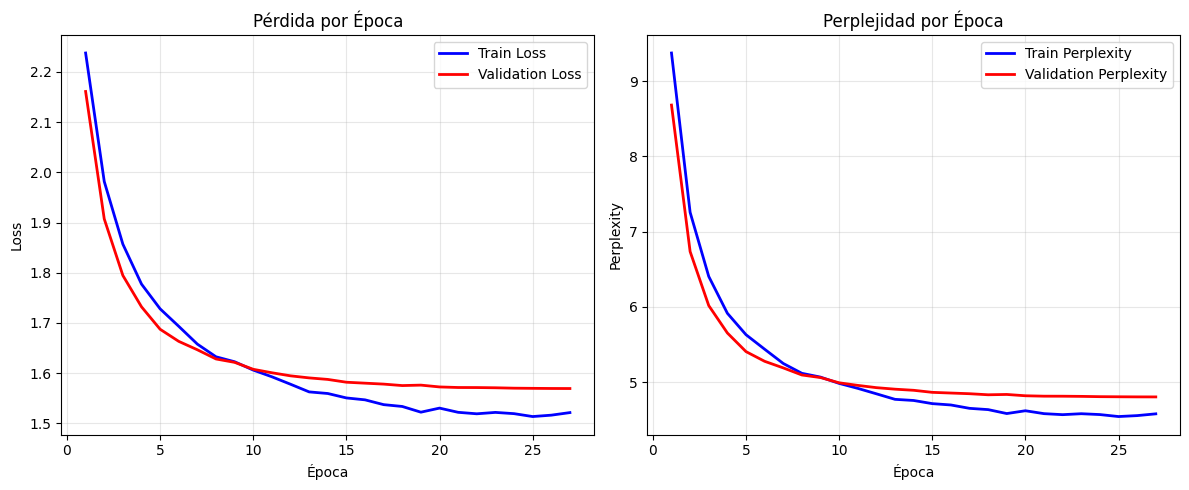

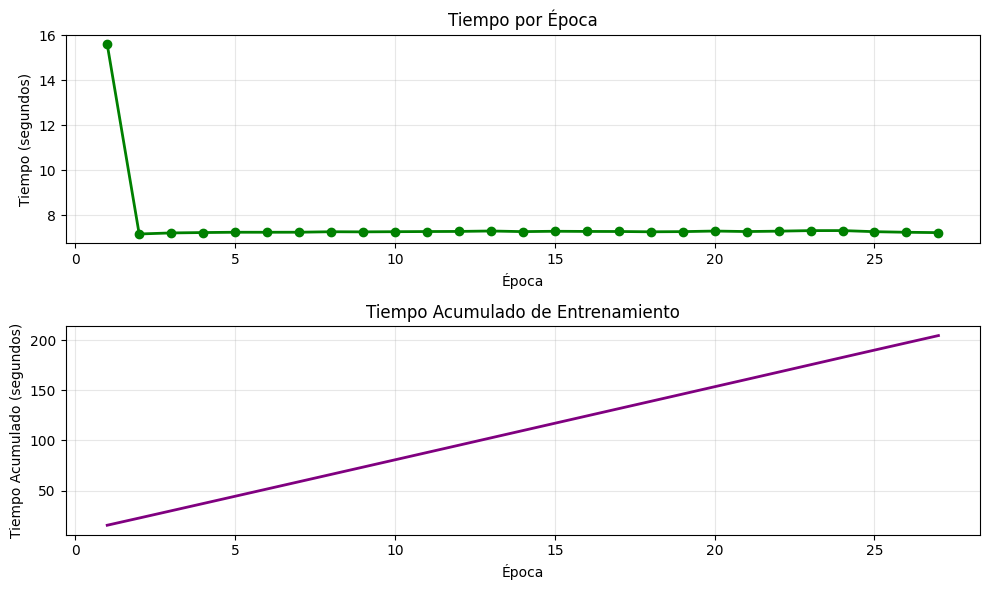


=== Resumen de Entrenamiento ===
Épocas totales: 27
Tiempo total: 204.45s (3.4 min)
Tiempo promedio por época: 7.57s
Loss final - Train: 1.5214, Val: 1.5693
Perplexity final - Train: 4.5786, Val: 4.8035


In [51]:
# Cargar y visualizar métricas
from metrics_logger import load_and_plot_metrics, compare_models_metrics

# Visualizar métricas de un modelo
metrics = load_and_plot_metrics("tinygpt_metrics.json", save_plots=True)

# Si tienes múltiples modelos para comparar:
# compare_models_metrics(
#     ["tinygpt_metrics.json", "tinygpt_moe_metrics.json"],
#     ["TinyGPT Base", "TinyGPT MoE"]
# )

#### Prueba rápida

In [56]:
generate(model=model, prompt="To be", max_new_tokens=100, use_cache=True, device=device) 

'To besenemvion, that of they are the peomple, our good\ndoth aws barn should ret.\n\nCORIOLANUS:\nWe conventu'

## Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

In [57]:
# TODO Implementar decodificación Greedy, Temperature y top_k/top_p
@torch.no_grad()
def generateV2(
    model: torch.nn.Module,
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
    do_sample: bool = True,
    device: torch.device = None
) -> str:
    """
    Función de generación mejorada con múltiples estrategias de decodificación.
    
    Args:
        model: Modelo TinyGPT entrenado
        prompt: Texto inicial para la generación
        max_new_tokens: Número máximo de tokens a generar
        use_cache: Si usar KV cache para acelerar la inferencia
        temperature: Temperatura para el muestreo (1.0 = sin cambios, <1 = más conservador, >1 = más aleatorio)
        top_k: Número de tokens top-k a considerar (0 = desactivado)
        top_p: Umbral de probabilidad acumulada para nucleus sampling (1.0 = desactivado)
        do_sample: Si usar muestreo (False = greedy decoding)
        device: Device donde ejecutar la inferencia
    
    Returns:
        Texto generado completo (prompt + tokens generados)
    """
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None
    
    for _ in range(max_new_tokens):
        # Preparar input condicionado según si usamos cache
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]  # Solo el último token
        else:
            idx_cond = idx[:, -config.block_size:]  # Ventana completa
        
        # Forward pass
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)
        
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None
        
        # Obtener logits del último token
        logits = logits[:, -1, :] / temperature  # Aplicar temperatura
        
        if do_sample:
            # === MUESTREO ===
            
            # Top-k filtering
            if top_k > 0:
                # Obtener los top-k logits más altos
                top_k_logits, top_k_indices = torch.topk(logits, min(top_k, logits.size(-1)))
                # Crear máscara para filtrar el resto
                logits_filtered = torch.full_like(logits, float('-inf'))
                logits_filtered.scatter_(1, top_k_indices, top_k_logits)
                logits = logits_filtered
            
            # Top-p (nucleus) filtering
            if top_p < 1.0:
                # Ordenar logits de mayor a menor
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                # Calcular probabilidades acumuladas
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                
                # Crear máscara para tokens que exceden top_p
                sorted_indices_to_remove = cumulative_probs > top_p
                # Mantener al menos el primer token (el más probable)
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                
                # Aplicar máscara a logits ordenados
                sorted_logits[sorted_indices_to_remove] = float('-inf')
                # Reordenar de vuelta a posiciones originales
                logits = torch.gather(sorted_logits, 1, sorted_indices.argsort(1))
            
            # Convertir a probabilidades y muestrear
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
        else:
            # === DECODIFICACIÓN GREEDY ===
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        
        # Concatenar el nuevo token
        idx = torch.cat((idx, next_token), dim=1)
    
    return decode(idx[0].tolist())


def top_k_top_p_filtering(logits: torch.Tensor, top_k: int = 0, top_p: float = 1.0) -> torch.Tensor:
    """
    Función auxiliar para filtrado top-k y top-p.
    """
    if top_k > 0:
        # Top-k filtering
        top_k = min(max(top_k, 1), logits.size(-1))  # Safety check
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = float('-inf')

    if top_p < 1.0:
        # Top-p filtering
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        # Scatter sorted tensors to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = float('-inf')
    
    return logits


# Función de conveniencia para diferentes modos de generación
@torch.no_grad()
def generate_greedy(model, prompt: str, max_new_tokens: int = 100, **kwargs):
    """Generación greedy (determinística)"""
    return generateV2(
        model=model, 
        prompt=prompt, 
        max_new_tokens=max_new_tokens, 
        do_sample=False, 
        **kwargs
    )


@torch.no_grad()
def generate_with_temperature(model, prompt: str, temperature: float = 0.8, max_new_tokens: int = 100, **kwargs):
    """Generación con temperatura"""
    return generateV2(
        model=model, 
        prompt=prompt, 
        max_new_tokens=max_new_tokens, 
        temperature=temperature, 
        do_sample=True, 
        top_k=0, 
        top_p=1.0, 
        **kwargs
    )


@torch.no_grad()
def generate_top_k(model, prompt: str, top_k: int = 10, max_new_tokens: int = 100, **kwargs):
    """Generación con top-k sampling"""
    return generateV2(
        model=model, 
        prompt=prompt, 
        max_new_tokens=max_new_tokens, 
        top_k=top_k, 
        top_p=1.0, 
        do_sample=True, 
        **kwargs
    )


@torch.no_grad()
def generate_nucleus(model, prompt: str, top_p: float = 0.9, max_new_tokens: int = 100, **kwargs):
    """Generación con nucleus (top-p) sampling"""
    return generateV2(
        model=model, 
        prompt=prompt, 
        max_new_tokens=max_new_tokens, 
        top_k=0, 
        top_p=top_p, 
        do_sample=True, 
        **kwargs
    )

#### Comparar `generate` vs `generateV2`

Añade tus comentarios y conclusiones

In [58]:
# Comparar diferentes métodos de generación
prompt = "To be"

print("=== GENERACIÓN ORIGINAL ===")
result_original = generate(model=model, prompt=prompt, max_new_tokens=50, use_cache=True, device=device)
print(result_original)

print("\n=== DECODIFICACIÓN GREEDY ===")
result_greedy = generate_greedy(model, prompt, max_new_tokens=50, device=device)
print(result_greedy)

print("\n=== MUESTREO CON TEMPERATURA (0.5) ===")
result_temp_low = generate_with_temperature(model, prompt, temperature=0.5, max_new_tokens=50, device=device)
print(result_temp_low)

print("\n=== MUESTREO CON TEMPERATURA (1.5) ===")
result_temp_high = generate_with_temperature(model, prompt, temperature=1.5, max_new_tokens=50, device=device)
print(result_temp_high)

print("\n=== TOP-K SAMPLING (k=5) ===")
result_top_k = generate_top_k(model, prompt, top_k=5, max_new_tokens=50, device=device)
print(result_top_k)

print("\n=== NUCLEUS SAMPLING (p=0.9) ===")
result_nucleus = generate_nucleus(model, prompt, top_p=0.9, max_new_tokens=50, device=device)
print(result_nucleus)

print("\n=== COMBINADO: Top-k + Top-p + Temperatura ===")
result_combined = generateV2(
    model=model, 
    prompt=prompt, 
    max_new_tokens=50, 
    temperature=0.8, 
    top_k=10, 
    top_p=0.9, 
    device=device
)
print(result_combined)

=== GENERACIÓN ORIGINAL ===
To be it, as scannon's prued almain exer in their say
l

=== DECODIFICACIÓN GREEDY ===
To be the people,
That the people, the people, the peop

=== MUESTREO CON TEMPERATURA (0.5) ===
To be stand you must him would privants the never stron

=== MUESTREO CON TEMPERATURA (1.5) ===
To best Coriolty's to enow from't 
LARTIUS:
SirlanCitiz

=== TOP-K SAMPLING (k=5) ===
To betty that those are too accuse.

COMINIUS:
I have s

=== NUCLEUS SAMPLING (p=0.9) ===
To better yourselves,
He be make bell's he loves soul.


=== COMBINADO: Top-k + Top-p + Temperatura ===
To be and the belly they proud.

CORIOLANUS:
What have 


## Tarea II

Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [15]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        return self.net(x)


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [16]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        # x shape: (batch_size, seq_len, n_embd)
        batch_size, seq_len, n_embd = x.shape
        
        # Flatten para procesar todos los tokens juntos
        x_flat = x.view(-1, n_embd)  # (batch_size * seq_len, n_embd)
        
        # Obtener puntuaciones del gate para cada token
        gate_logits = self.gate(x_flat)  # (batch_size * seq_len, num_experts)
        gate_scores = F.softmax(gate_logits, dim=-1)  # (batch_size * seq_len, num_experts)
        
        # Seleccionar top-k expertos por token
        top_k_scores, top_k_indices = torch.topk(
            gate_scores, 
            k=self.args.num_experts_per_token, 
            dim=-1
        )
        # top_k_scores: (batch_size * seq_len, num_experts_per_token)
        # top_k_indices: (batch_size * seq_len, num_experts_per_token)
        
        # Normalizar las puntuaciones de los expertos seleccionados
        top_k_scores = top_k_scores / top_k_scores.sum(dim=-1, keepdim=True)
        
        # Inicializar salida
        output = torch.zeros_like(x_flat)  # (batch_size * seq_len, n_embd)
        
        # Procesar cada experto
        for expert_idx, expert in enumerate(self.experts):
            # Crear máscara para tokens que usan este experto
            expert_mask = (top_k_indices == expert_idx).any(dim=-1)  # (batch_size * seq_len,)
            
            if expert_mask.any():
                # Tokens que usan este experto
                expert_tokens = x_flat[expert_mask]  # (num_tokens_using_expert, n_embd)
                
                # Procesar con el experto
                expert_output = expert(expert_tokens)  # (num_tokens_using_expert, n_embd)
                
                # Obtener pesos para este experto en los tokens correspondientes
                token_indices = torch.where(expert_mask)[0]
                for i, token_idx in enumerate(token_indices):
                    # Encontrar la posición de este experto en top_k para este token
                    expert_positions = (top_k_indices[token_idx] == expert_idx)
                    if expert_positions.any():
                        expert_weight = top_k_scores[token_idx][expert_positions].sum()
                        output[token_idx] += expert_weight * expert_output[i]
        
        # Reshape de vuelta a la forma original
        output = output.view(batch_size, seq_len, n_embd)
        
        return output

In [17]:
class MoELayerOptimized(nn.Module):
    """
    Versión optimizada de MoE con mejor paralelización
    """
    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args
        self.num_experts = len(experts)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, n_embd = x.shape
        x_flat = x.view(-1, n_embd)
        
        # Gate computation
        gate_logits = self.gate(x_flat)
        gate_scores = F.softmax(gate_logits, dim=-1)
        
        # Top-k selection
        top_k_scores, top_k_indices = torch.topk(
            gate_scores, k=self.args.num_experts_per_token, dim=-1
        )
        top_k_scores = top_k_scores / top_k_scores.sum(dim=-1, keepdim=True)
        
        # Preparar para procesamiento paralelo
        output = torch.zeros_like(x_flat)
        
        # Procesar todos los expertos en paralelo cuando sea posible
        for expert_idx, expert in enumerate(self.experts):
            # Máscara más eficiente
            expert_mask = (top_k_indices == expert_idx)
            if expert_mask.any():
                # Obtener pesos y posiciones
                weights = top_k_scores * expert_mask.float()
                weights_sum = weights.sum(dim=-1, keepdim=True)
                
                # Solo procesar tokens que realmente usan este experto
                active_tokens = weights_sum.squeeze() > 0
                if active_tokens.any():
                    expert_input = x_flat[active_tokens]
                    expert_out = expert(expert_input)
                    
                    # Aplicar pesos de forma vectorizada
                    final_weights = weights_sum[active_tokens]
                    output[active_tokens] += final_weights * expert_out
        
        return output.view(batch_size, seq_len, n_embd)

In [18]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayerOptimized(  
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)

#### Añadiendo MoE a la configuración

In [29]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)

config.batch_size = 256  # Reducir batch size para compensar mayor uso de memoria

#### Entrenamiento de TinyGPT‑MoE

In [30]:
print(device)

cuda


In [31]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [32]:
# Optimizer, scheduler, and loss function
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
# scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
total_steps = len(train_loader) * epochs
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 25

In [33]:
logger = MetricsLogger("moe_metrics.json")

trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints_moe",
    save_every_n=500,
)

# Entrenamiento con logging
logger.start_training()

for epoch in range(epochs):
    logger.start_epoch()
    
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    val_loss = trainer.eval_model()
    
    # Corregir la pérdida de entrenamiento si está dividida por gradient_accumulation_steps
    corrected_train_loss = avg_train_loss * trainer.gradient_accumulation_steps
    
    # Log de métricas
    logger.log_epoch(corrected_train_loss, val_loss)

logger.end_training()
logger.save_metrics()

print("Entrenamiento completo.")

val_loss 2.23398: 100%|██████████| 19/19 [00:00<00:00, 36.16it/s]


Época 1 - Train Loss: 2.3873 - Val Loss: 2.3308
Train Perplexity: 10.8840 - Val Perplexity: 10.2860
Tiempo de época: 11.13s


val_loss 1.95007: 100%|██████████| 19/19 [00:00<00:00, 36.63it/s]


Época 2 - Train Loss: 2.1795 - Val Loss: 2.1026
Train Perplexity: 8.8415 - Val Perplexity: 8.1875
Tiempo de época: 11.07s


val_loss 1.77407: 100%|██████████| 19/19 [00:00<00:00, 34.08it/s]


Época 3 - Train Loss: 2.0128 - Val Loss: 1.9415
Train Perplexity: 7.4844 - Val Perplexity: 6.9690
Tiempo de época: 11.06s


val_loss 1.69725: 100%|██████████| 19/19 [00:00<00:00, 38.36it/s]


Época 4 - Train Loss: 1.9301 - Val Loss: 1.8605
Train Perplexity: 6.8902 - Val Perplexity: 6.4267
Tiempo de época: 11.12s


val_loss 1.63759: 100%|██████████| 19/19 [00:00<00:00, 37.47it/s]


Época 5 - Train Loss: 1.8548 - Val Loss: 1.7893
Train Perplexity: 6.3905 - Val Perplexity: 5.9854
Tiempo de época: 10.86s


val_loss 1.60543: 100%|██████████| 19/19 [00:00<00:00, 38.35it/s]


Época 6 - Train Loss: 1.8120 - Val Loss: 1.7565
Train Perplexity: 6.1226 - Val Perplexity: 5.7920
Tiempo de época: 11.01s


val_loss 1.56804: 100%|██████████| 19/19 [00:00<00:00, 36.80it/s]


Época 7 - Train Loss: 1.7587 - Val Loss: 1.7117
Train Perplexity: 5.8047 - Val Perplexity: 5.5385
Tiempo de época: 10.57s


val_loss 1.55018: 100%|██████████| 19/19 [00:00<00:00, 38.52it/s]


Época 8 - Train Loss: 1.7363 - Val Loss: 1.6969
Train Perplexity: 5.6764 - Val Perplexity: 5.4570
Tiempo de época: 10.60s


val_loss 1.51789: 100%|██████████| 19/19 [00:00<00:00, 39.05it/s]


Época 9 - Train Loss: 1.6915 - Val Loss: 1.6633
Train Perplexity: 5.4277 - Val Perplexity: 5.2765
Tiempo de época: 10.52s


val_loss 1.51071: 100%|██████████| 19/19 [00:00<00:00, 34.78it/s]


Época 10 - Train Loss: 1.6925 - Val Loss: 1.6562
Train Perplexity: 5.4331 - Val Perplexity: 5.2394
Tiempo de época: 11.07s


val_loss 1.48630: 100%|██████████| 19/19 [00:00<00:00, 36.18it/s]


Época 11 - Train Loss: 1.6540 - Val Loss: 1.6330
Train Perplexity: 5.2278 - Val Perplexity: 5.1194
Tiempo de época: 11.01s


val_loss 1.49014: 100%|██████████| 19/19 [00:00<00:00, 35.80it/s]


Época 12 - Train Loss: 1.6508 - Val Loss: 1.6313
Train Perplexity: 5.2110 - Val Perplexity: 5.1104
Tiempo de época: 11.01s


val_loss 1.46876: 100%|██████████| 19/19 [00:00<00:00, 35.73it/s]


Época 13 - Train Loss: 1.6157 - Val Loss: 1.6120
Train Perplexity: 5.0316 - Val Perplexity: 5.0128
Tiempo de época: 10.98s


val_loss 1.46792: 100%|██████████| 19/19 [00:00<00:00, 33.80it/s]


Época 14 - Train Loss: 1.6196 - Val Loss: 1.6137
Train Perplexity: 5.0509 - Val Perplexity: 5.0216
Tiempo de época: 11.03s


val_loss 1.44612: 100%|██████████| 19/19 [00:00<00:00, 35.63it/s]


Época 15 - Train Loss: 1.5910 - Val Loss: 1.5958
Train Perplexity: 4.9088 - Val Perplexity: 4.9323
Tiempo de época: 10.92s


val_loss 1.44249: 100%|██████████| 19/19 [00:00<00:00, 35.62it/s]


Época 16 - Train Loss: 1.5954 - Val Loss: 1.5964
Train Perplexity: 4.9303 - Val Perplexity: 4.9353
Tiempo de época: 10.84s


val_loss 1.42961: 100%|██████████| 19/19 [00:00<00:00, 36.13it/s]


Época 17 - Train Loss: 1.5756 - Val Loss: 1.5828
Train Perplexity: 4.8337 - Val Perplexity: 4.8685
Tiempo de época: 10.94s


val_loss 1.44229: 100%|██████████| 19/19 [00:00<00:00, 36.45it/s]


Época 18 - Train Loss: 1.5718 - Val Loss: 1.5913
Train Perplexity: 4.8154 - Val Perplexity: 4.9099
Tiempo de época: 11.02s


val_loss 1.41596: 100%|██████████| 19/19 [00:00<00:00, 35.70it/s]


Época 19 - Train Loss: 1.5456 - Val Loss: 1.5744
Train Perplexity: 4.6906 - Val Perplexity: 4.8277
Tiempo de época: 11.04s


val_loss 1.41863: 100%|██████████| 19/19 [00:00<00:00, 36.05it/s]


Época 20 - Train Loss: 1.5596 - Val Loss: 1.5824
Train Perplexity: 4.7570 - Val Perplexity: 4.8666
Tiempo de época: 10.96s


val_loss 1.40960: 100%|██████████| 19/19 [00:00<00:00, 35.28it/s]


Época 21 - Train Loss: 1.5300 - Val Loss: 1.5672
Train Perplexity: 4.6183 - Val Perplexity: 4.7930
Tiempo de época: 11.12s


val_loss 1.41902: 100%|██████████| 19/19 [00:00<00:00, 35.35it/s]


Época 22 - Train Loss: 1.5412 - Val Loss: 1.5743
Train Perplexity: 4.6704 - Val Perplexity: 4.8275
Tiempo de época: 11.03s


val_loss 1.40382: 100%|██████████| 19/19 [00:00<00:00, 36.36it/s]


Época 23 - Train Loss: 1.5173 - Val Loss: 1.5614
Train Perplexity: 4.5597 - Val Perplexity: 4.7654
Tiempo de época: 11.00s


val_loss 1.40925: 100%|██████████| 19/19 [00:00<00:00, 36.45it/s]


Época 24 - Train Loss: 1.5186 - Val Loss: 1.5682
Train Perplexity: 4.5658 - Val Perplexity: 4.7979
Tiempo de época: 10.96s


val_loss 1.39777: 100%|██████████| 19/19 [00:00<00:00, 34.44it/s]

Época 25 - Train Loss: 1.4966 - Val Loss: 1.5567
Train Perplexity: 4.4665 - Val Perplexity: 4.7431
Tiempo de época: 11.06s
Entrenamiento completo. Tiempo total: 273.91s
Métricas guardadas en moe_metrics.json
Entrenamiento completo.


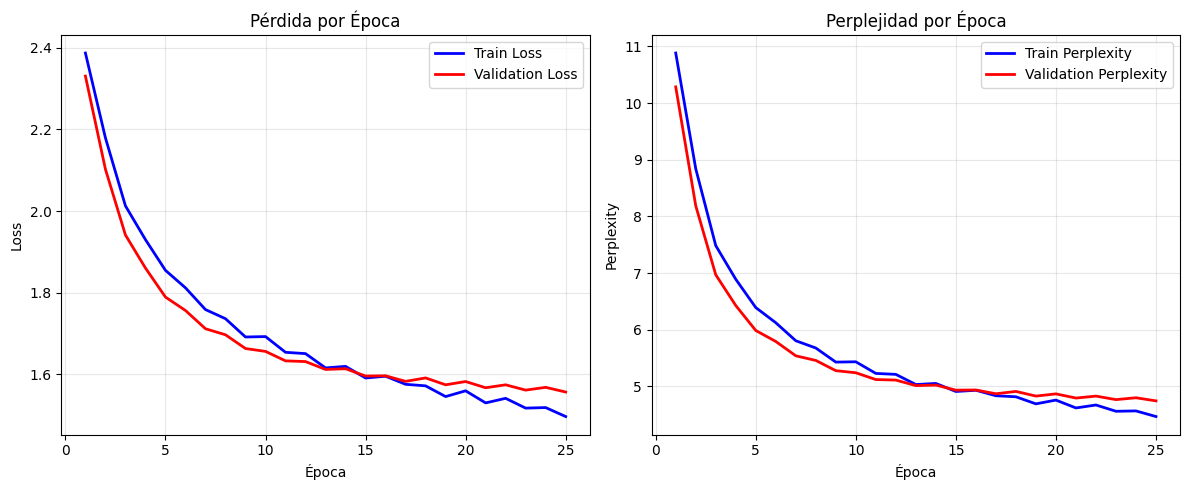

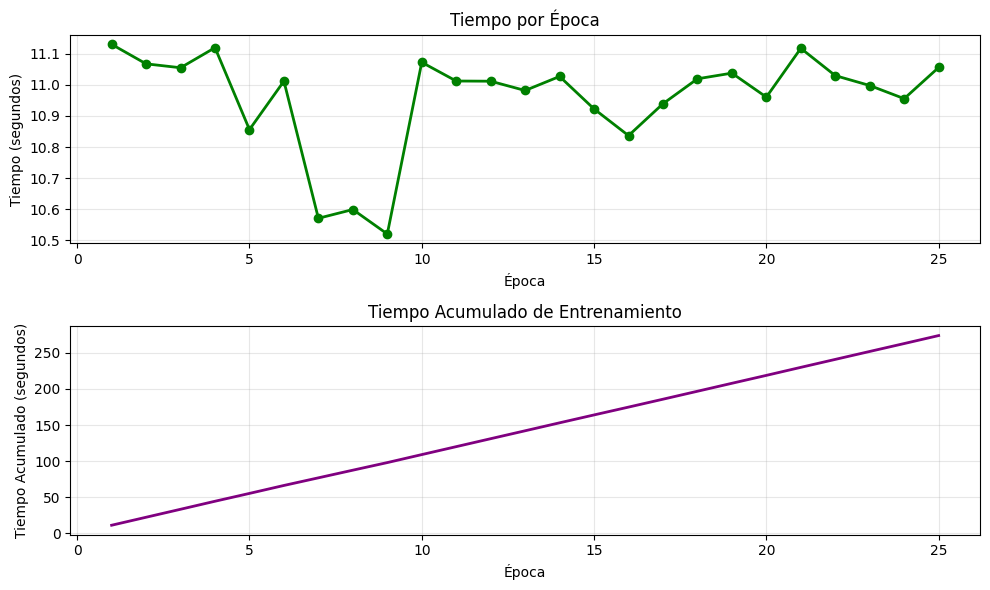


=== Resumen de Entrenamiento ===
Épocas totales: 25
Tiempo total: 273.91s (4.6 min)
Tiempo promedio por época: 10.96s
Loss final - Train: 1.4966, Val: 1.5567
Perplexity final - Train: 4.4665, Val: 4.7431


In [34]:
# Visualizar métricas de un modelo
metrics = load_and_plot_metrics("moe_metrics.json", save_plots=True)

In [35]:
generate(model=model_moe, prompt="To be", max_new_tokens=100, use_cache=True, device=device) 

'To be were now of the people, iwman my your put bear\nTo will smity help and power so his that the not nob'

#### Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [43]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

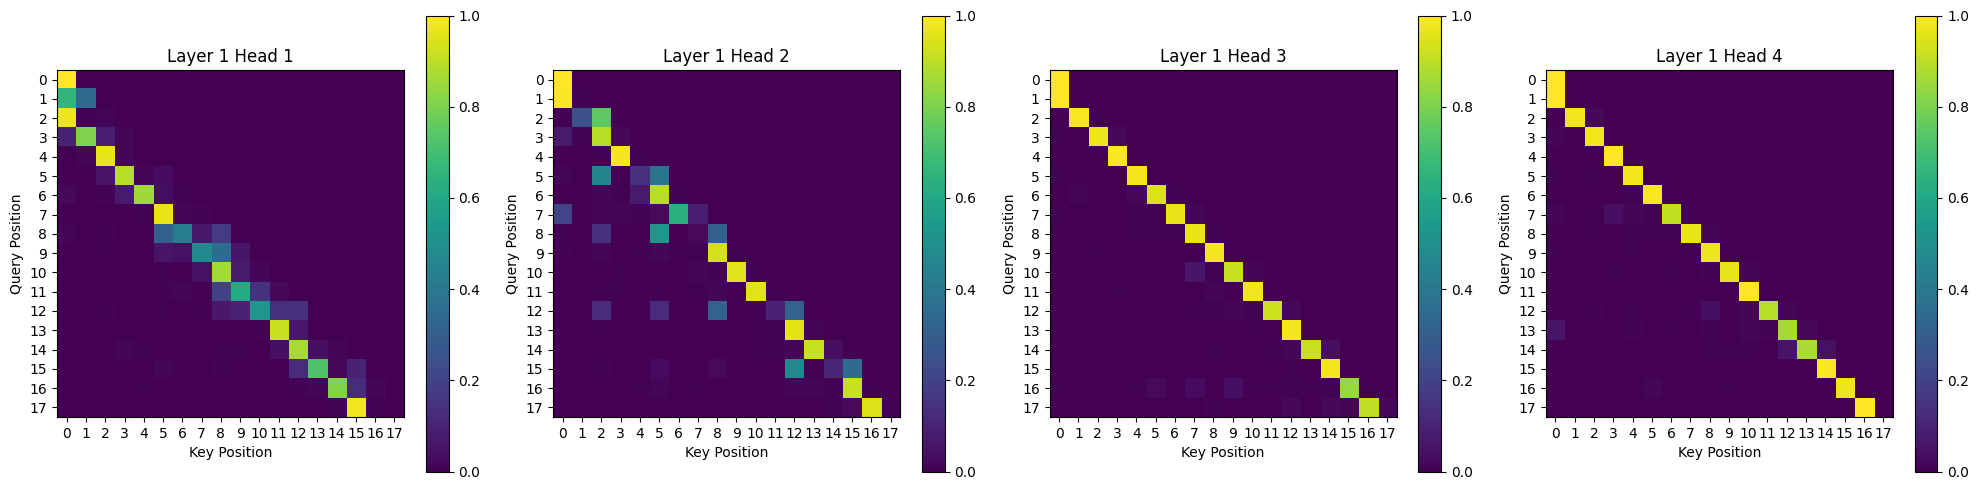

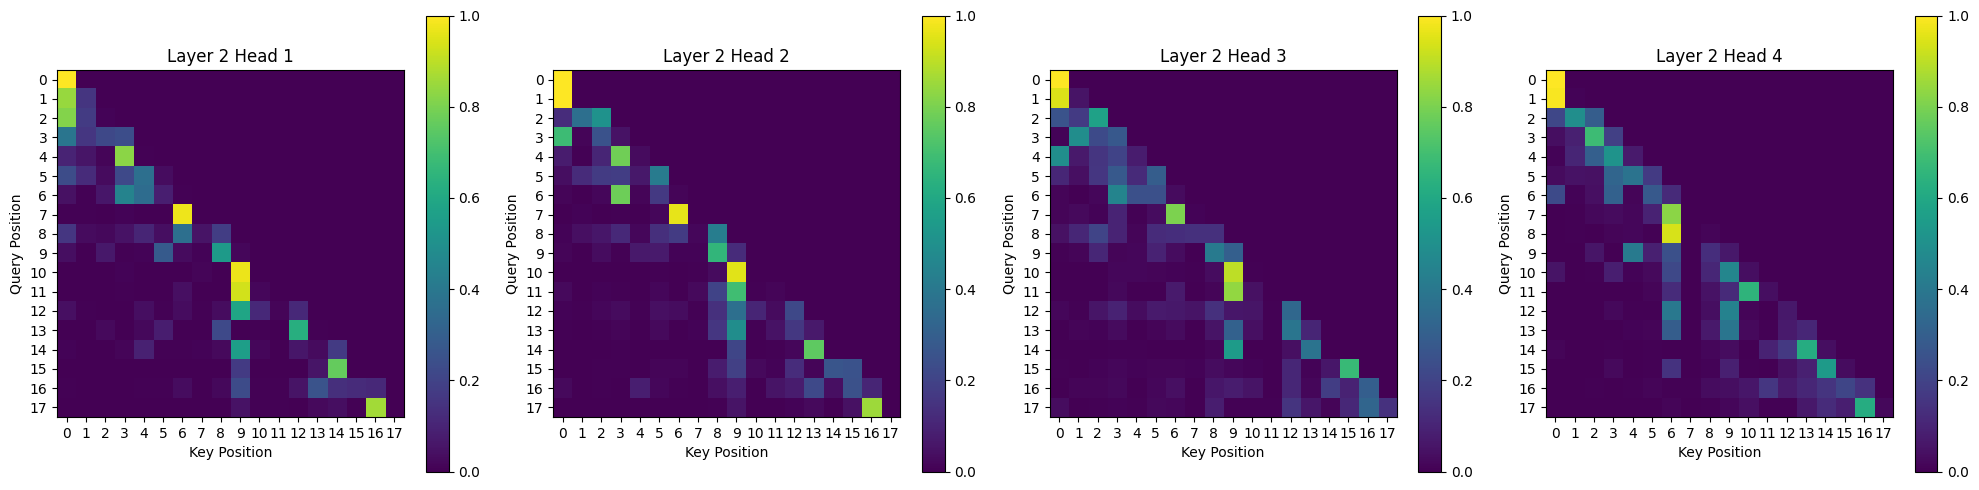

In [45]:
prompt = "To be or not to be"
visualize_attention(model_moe, prompt)

## Conclusiones